<a href="https://colab.research.google.com/github/lifesboy/selks-lstm-data/blob/main/SELKS_LSTM_Anomaly_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.LSTM KERAS

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

# 2.PREPARATION

In [1]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-01-25 02:21:25.068540: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import ray
import pyarrow
import pyarrow as pa
from pyarrow import csv
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras import Input


import common
from anomaly_normalization import PS, LABEL, PAYLOAD_FEATURE_NUM, ALL_FEATURES
from aimodels.preprocessing.cicflowmeter_norm_model import CicFlowmeterNormModel
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, show_train_metric, IMG,\
read_csv_in_dir, read_csv_in_dir_label_string

run, client = common.init_experiment(name='notebook')


2023-01-25 02:21:27.407086: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 1240 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-01-25 02:21:27.408783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13129 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-01-25 02:21:27.409815: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13129 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-01-25 02:21:27.411319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:3 with 13129 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:42:00.0, compute capability: 8.6
2023-01-25 02:21:30,157[INFO][139839742060352-MainThread] worker.py:init(957) Connecting to existing Ray cluster at address: 

# 3.INPUT
Let's generate a sample input with time dimension as below:

In [3]:
#@title Generate an input sequence
#10.0.2.10
#10.0.2.155
#10.0.2.180
#10.0.2.181
#10.0.2.182
#192.168.66.39
#192.168.66.21

cell_size = 256 #@param {type:"integer"} #numberOfLSTMunits
hidden_size = 128 #@param {type:"integer"}
n_timesteps_in = 100  #@param {type:"integer"}
n_features = 50   #@param {type:"integer"}

# generate datasets
train_size= 20 #@param {type:"integer"}
test_size = 5  #@param {type:"integer"}
batch_size=32 #@param {type:"integer"}
epochs=100 #@param {type:"integer"}

L_fsource = '/cic/dataset/featured_extracted/cic2018/Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv.00001.csv.00006.csv' #@param {type:"string"}
L_fdata: Dataset = read_csv_in_dir_label_string(L_fsource)
L_fcount: DataFrame = L_fdata.groupby(LABEL).aggregate(Count()).to_pandas()

features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
#features = [*features, *[PS % i for i in range(0, PAYLOAD_FEATURE_NUM)]]
features = features[0: n_features]
Lfpadding_features = sorted(list(set(features) - set(L_fdata.schema(fetch_if_missing=True).names)))

print ('features=', features)
print ('Lfpadding_features=', Lfpadding_features)

L_ftrain = DataFrame.from_records(L_fdata.take(train_size * n_timesteps_in)).fillna(0).replace([np.inf, -np.inf], 0)
L_ftrain[Lfpadding_features] = 0
#L_ftrain[LABEL] = L_ftrain.apply(lambda x: 'Anomaly' if x['src_ip'] == '192.168.66.39' else 'Benign', axis=1)
L_ftrain[LABEL] = L_ftrain[LABEL].apply(lambda x: 0 if x == 'Benign' else 1)
LX_ftrain = L_ftrain[features].to_numpy().reshape(train_size, n_timesteps_in, n_features)
Ly_ftrain = L_ftrain[[LABEL]].to_numpy().reshape(train_size, n_timesteps_in)

L_ftest = DataFrame.from_records(L_fdata.take(test_size * n_timesteps_in)).fillna(0).replace([np.inf, -np.inf], 0)
L_ftest[Lfpadding_features] = 0
#L_ftest[LABEL] = L_ftest.apply(lambda x: 'Anomaly' if x['src_ip'] == '192.168.66.39' else 'Benign', axis=1)
L_ftest[LABEL] = L_ftest[LABEL].apply(lambda x: 0 if x == 'Benign' else 1)
LX_ftest = L_ftest[features].to_numpy().reshape(test_size, n_timesteps_in, n_features)
Ly_ftest = L_ftest[[LABEL]].to_numpy().reshape(test_size, n_timesteps_in)

2023-01-25 02:21:32,056	WARNING read_api.py:256 -- The number of blocks in this dataset (1) limits its parallelism to 1 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 74.78it/s]


features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags']
Lfpadding_features= []


In [4]:
L_fcount

,label,count()
0,Benign,49950
1,DDOS attack-HOIC,50050


## Data preview

### L_ftrain preview

In [5]:
L_ftrain[[LABEL, *features]]

,label,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,bwd_iat_min,bwd_iat_std,bwd_iat_tot,bwd_pkt_len_max,bwd_pkt_len_mean,bwd_pkt_len_min,bwd_pkt_len_std,bwd_pkts_b_avg,bwd_pkts_s,bwd_psh_flags,bwd_seg_size_avg,bwd_urg_flags,cwe_flag_count,down_up_ratio,dst_port,ece_flag_cnt,fin_flag_cnt,flow_byts_s,flow_duration,flow_iat_max,flow_iat_mean,flow_iat_min,flow_iat_std,flow_pkts_s,fwd_act_data_pkts,fwd_blk_rate_avg,fwd_byts_b_avg,fwd_header_len,fwd_iat_max,fwd_iat_mean,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.000000e+00,4291.0,4291.0,4291.000000,4291.0,0.000000,466.091820,0.0,0.0,0.0,40.0,4291.0,4291.00,4291.0,0.000000,4291.0,0.0,0.0,0.0,0.000000,0.0,466.091820,0.0
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.000000e+00,26495.0,26495.0,26495.000000,26495.0,0.000000,75.485941,0.0,0.0,0.0,40.0,26495.0,26495.00,26495.0,0.000000,26495.0,0.0,0.0,0.0,0.000000,0.0,75.485941,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,649.0,649.0,649.0,0.0,649.0,326.0,163.0,0.0,230.516811,0.0,1655.629139,0.0,163.0,0.0,0.0,0.0,52250.0,1.0,0.0,1.043874e+06,1208.0,649.0,201.333333,4.0,253.386398,5794.701987,1.0,0.0,0.0,124.0,972.0,302.00,4.0,455.739692,1208.0,935.0,187.0,0.0,418.144712,0.0,4139.072848,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,593.0,593.0,593.0,0.0,593.0,323.0,161.5,0.0,228.395490,0.0,1776.198934,0.0,161.5,0.0,0.0,0.0,51853.0,1.0,0.0,1.117229e+06,1126.0,593.0,187.666667,4.0,230.688246,6216.696270,1.0,0.0,0.0,124.0,893.0,281.50,4.0,417.144659,1126.0,935.0,187.0,0.0,418.144712,0.0,4440.497336,0.0
4,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.000000e+00,2556.0,2556.0,2556.000000,2556.0,0.000000,782.472613,0.0,0.0,0.0,40.0,2556.0,2556.00,2556.0,0.000000,2556.0,0.0,0.0,0.0,0.000000,0.0,782.472613,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.000000e+00,878.0,878.0,878.000000,878.0,0.000000,2277.904328,0.0,0.0,0.0,40.0,878.0,878.00,878.0,0.000000,878.0,0.0,0.0,0.0,0.000000,0.0,2277.904328,0.0
1996,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,4311.0,4311.0,4311.0,0.0,4311.0,325.0,162.5,0.0,229.809704,0.0,407.331976,0.0,162.5,0.0,0.0,0.0,49337.0,1.0,0.0,2.566191e+05,4910.0,4311.0,818.333333,6.0,1716.386165,1425.661914,1.0,0.0,0.0,124.0,4657.0,1227.50,6.0,2288.389317,4910.0,935.0,187.0,0.0,418.144712,0.0,1018.329939,0.0
1997,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.000000e+00,4426.0,4426.0,4426.000000,4426.0,0.000000,451.875282,0.0,0.0,0.0,40.0,4426.0,4426.00,4426.0,0.000000,4426.0,0.0,0.0,0.0,0.000000,0.0,451.875282,0.0
1998,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,560.0,560.0,560.0,0.0,560.0,272.0,136.0,0.0,192.333044,0.0,1846.722068,0.0,136.0,0.0,0.0,0.0,52137.0,1.0,0.0,1.114497e+06,1083.0,560.0,180.500000,7.0,219.812420,6463.527239,1.0,0.0,0.0,124.0,862.0,270.75,7.0,402.581979,1083.0,935.0,187.0,0.0,418.144712,0.0,4616.805171,0.0


In [6]:
L_ftrain[[LABEL, *features]].describe()

,label,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,bwd_iat_min,bwd_iat_std,bwd_iat_tot,bwd_pkt_len_max,bwd_pkt_len_mean,bwd_pkt_len_min,bwd_pkt_len_std,bwd_pkts_b_avg,bwd_pkts_s,bwd_psh_flags,bwd_seg_size_avg,bwd_urg_flags,cwe_flag_count,down_up_ratio,dst_port,ece_flag_cnt,fin_flag_cnt,flow_byts_s,flow_duration,flow_iat_max,flow_iat_mean,flow_iat_min,flow_iat_std,flow_pkts_s,fwd_act_data_pkts,fwd_blk_rate_avg,fwd_byts_b_avg,fwd_header_len,fwd_iat_max,fwd_iat_mean,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags
count,2000.000000,2000.000000,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.000000,2000.000000,2000.000000,2000.0,2000.000000,2000.0,2000.000000,2000.0,2000.000000,2000.0,2000.0,2000.0,2000.0000,2000.000000,2000.0,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.0,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.000000,2000.0,2000.000000,2000.0
mean,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,20.000000,1348.896000,1348.896000,1348.896000,0.0,1348.896000,149.218500,74.609250,0.0,105.513413,0.0,643.159904,0.0,74.609250,0.0,0.0,0.0,26099.7635,0.500000,0.0,3.962066e+05,5451.291000,5162.564000,4080.618500,3809.286000,543.304779,2559.307310,0.500000,0.0,0.0,82.000000,5319.167500,4217.68575,3809.352000,739.176786,5451.291000,467.500000,93.500000,0.0,209.072356,0.0,1916.147406,0.0
std,0.500125,0.500125,0.0,0.0,0.0,0.0,0.0,0.0,20.005002,3432.056342,3432.056342,3432.056342,0.0,3432.056342,150.740393,75.370197,0.0,106.589554,0.0,770.317335,0.0,75.370197,0.0,0.0,0.0,26189.4288,0.500125,0.0,4.745140e+05,6813.064301,6905.045132,6670.092595,6797.312498,1389.618069,2486.009098,0.500125,0.0,0.0,42.010504,6854.721959,6624.78923,6797.275569,1742.236791,6813.064301,467.616919,93.523384,0.0,209.124644,0.0,1736.839618,0.0
min,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,80.0000,0.000000,0.0,0.000000e+00,474.000000,284.000000,130.166667,2.000000,0.000000,68.027211,0.000000,0.0,0.0,40.000000,474.000000,195.25000,2.000000,0.000000,474.000000,0.000000,0.000000,0.0,0.000000,0.0,68.027211,0.0
25%,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,80.0000,0.000000,0.0,0.000000e+00,1235.750000,701.000000,212.000000,6.000000,0.000000,428.882295,0.000000,0.0,0.0,40.000000,988.750000,318.00000,6.000000,0.000000,1235.750000,0.000000,0.000000,0.0,0.000000,0.0,390.472650,0.0
50%,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,20.000000,1.500000,1.500000,1.500000,0.0,1.500000,123.500000,61.750000,0.0,87.327687,0.0,29.873040,0.0,61.750000,0.0,0.0,0.0,24621.5000,0.500000,0.0,1.883495e+04,3040.500000,2947.000000,1436.583333,242.000000,66.067138,1059.045205,0.500000,0.0,0.0,82.000000,3003.500000,1781.87500,246.500000,121.874594,3040.500000,467.500000,93.500000,0.0,209.072356,0.0,928.720737,0.0
75%,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,40.000000,706.000000,706.000000,706.000000,0.0,706.000000,312.000000,156.000000,0.0,220.617316,0.0,1572.327044,0.0,156.000000,0.0,0.0,0.0,51853.2500,1.000000,0.0,9.634109e+05,5391.250000,5299.000000,4547.750000,4545.250000,273.510043,5503.144654,1.000000,0.0,0.0,124.000000,5339.000000,4555.50000,4545.250000,473.184535,5391.250000,935.000000,187.000000,0.0,418.144712,0.0,3933.910307,0.0
max,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,40.000000,32902.000000,32902.000000,32902.000000,0.0,32902.000000,341.000000,170.500000,0.0,241.123412,0.0,2560.819462,0.0,170.500000,0.0,0.0,0.0,63908.0000,1.000000,0.0,1.612658e+06,33475.000000,32902.000000,29400.000000,29400.000000,13386.0

In [7]:
DataFrame.from_records(LX_ftrain[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.000000e+00,4291.0,4291.0,4291.000000,4291.0,0.000000,466.091820,0.0,0.0,0.0,40.0,4291.0,4291.0,4291.0,0.000000,4291.0,0.0,0.0,0.0,0.000000,0.0,466.091820,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.000000e+00,26495.0,26495.0,26495.000000,26495.0,0.000000,75.485941,0.0,0.0,0.0,40.0,26495.0,26495.0,26495.0,0.000000,26495.0,0.0,0.0,0.0,0.000000,0.0,75.485941,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,649.0,649.0,649.0,0.0,649.0,326.0,163.0,0.0,230.516811,0.0,1655.629139,0.0,163.0,0.0,0.0,0.0,52250.0,1.0,0.0,1.043874e+06,1208.0,649.0,201.333333,4.0,253.386398,5794.701987,1.0,0.0,0.0,124.0,972.0,302.0,4.0,455.739692,1208.0,935.0,187.0,0.0,418.144712,0.0,4139.072848,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,593.0,593.0,593.0,0.0,593.0,323.0,161.5,0.0,228.395490,0.0,1776.198934,0.0,161.5,0.0,0.0,0.0,51853.0,1.0,0.0,1.117229e+06,1126.0,593.0,187.666667,4.0,230.688246,6216.696270,1.0,0.0,0.0,124.0,893.0,281.5,4.0,417.144659,1126.0,935.0,187.0,0.0,418.144712,0.0,4440.497336,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.000000e+00,2556.0,2556.0,2556.000000,2556.0,0.000000,782.472613,0.0,0.0,0.0,40.0,2556.0,2556.0,2556.0,0.000000,2556.0,0.0,0.0,0.0,0.000000,0.0,782.472613,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,15770.0,15770.0,15770.0,0.0,15770.0,272.0,136.0,0.0,192.333044,0.0,122.579064,0.0,136.0,0.0,0.0,0.0,63812.0,1.0,0.0,7.397646e+04,16316.0,15770.0,2719.333333,6.0,6394.601588,429.026722,1.0,0.0,0.0,124.0,16054.0,4079.0,6.0,7983.974866,16316.0,935.0,187.0,0.0,418.144712,0.0,306.447659,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,931.0,931.0,931.0,0.0,931.0,272.0,136.0,0.0,192.333044,0.0,1432.664756,0.0,136.0,0.0,0.0,0.0,63813.0,1.0,0.0,8.646132e+05,1396.0,931.0,232.666667,6.0,356.175051,5014.326648,1.0,0.0,0.0,124.0,1173.0,349.0,6.0,555.652769,1396.0,935.0,187.0,0.0,418.144712,0.0,3581.661891,0.0
97,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.000000e+00,955.0,955.0,955.000000,955.0,0.000000,2094.240838,0.0,0.0,0.0,40.0,955.0,955.0,955.0,0.000000,955.0,0.0,0.0,0.0,0.000000,0.0,2094.240838,0.0
98,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.000000e+00,5230.0,5230.0,5230.000000,5230.0,0.000000,382.409178,0.0,0.0,0.0,40.0,5230.0,5230.0,5230.0,0.000000,5230.0,0.0,0.0,0.0,0.000000,0.0,382.409178,0.0


In [8]:
DataFrame.from_records(LX_ftrain[0]).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
count,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.0,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.0,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.0,100.000000,100.0,100.000000,100.0
mean,0.510000,0.0,0.0,0.0,0.0,0.0,0.0,19.600000,1551.630000,1551.630000,1551.630000,0.0,1551.630000,141.040000,70.520000,0.0,99.730340,0.0,597.376641,0.0,70.520000,0.0,0.0,0.0,25552.860000,0.490000,0.0,3.651258e+05,5193.460000,4889.870000,3646.951667,3340.220000,623.669678,2440.056089,0.490000,0.0,0.0,81.160000,5063.390000,3801.602500,3340.260000,845.623110,5193.460000,458.150000,91.63000,0.0,204.890909,0.0,1842.679448,0.0
std,0.502418,0.0,0.0,0.0,0.0,0.0,0.0,20.096736,3753.533378,3753.533378,3753.533378,0.0,3753.533378,146.151846,73.075923,0.0,103.344961,0.0,751.223079,0.0,73.075923,0.0,0.0,0.0,26282.632268,0.502418,0.0,4.588214e+05,6269.613188,6333.378795,5901.727066,6039.265787,1517.837755,2408.587835,0.502418,0.0,0.0,42.203145,6294.145545,5858.322963,6039.243487,1909.146606,6269.613188,469.761198,93.95224,0.0,210.083594,0.0,1684.264354,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,80.000000,0.000000,0.0,0.000000e+00,502.000000,450.000000,175.333333,2.000000,0.000000,75.485941,0.000000,0.0,0.0,40.000000,502.000000,263.000000,2.000000,0.000000,502.000000,0.000000,0.00000,0.0,0.000000,0.0,75.485941,0.0
25%,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,80.000000,0.000000,0.0,0.000000e+00,1259.750000,711.000000,224.625000,6.000000,0.000000,434.008834,0.000000,0.0,0.0,40.000000,999.000000,336.937500,6.000000,0.000000,1259.750000,0.000000,0.00000,0.0,0.000000,0.0,417.604783,0.0
50%,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,80.000000,0.000000,0.0,0.000000e+00,2718.500000,2687.000000,1893.166667,652.500000,0.000000,1013.687513,0.000000,0.0,0.0,40.000000,2687.000000,1901.000000,652.500000,0.000000,2718.500000,0.000000,0.00000,0.0,0.000000,0.0,876.535161,0.0
75%,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,40.000000,701.000000,701.000000,701.000000,0.0,701.000000,273.000000,136.500000,0.0,193.040151,0.0,1484.329430,0.0,136.500000,0.0,0.0,0.0,51626.250000,1.000000,0.0,9.205968e+05,5315.750000,5078.500000,4277.500000,4277.500000,272.229592,5195.153004,1.000000,0.0,0.0,124.000000,5246.250000,4300.500000,4277.500000,478.998176,5315.750000,935.000000,187.00000,0.0,418.144712,0.0,3827.904159,0.0
max,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,40.000000,16521.000000,16521.000000,16521.000000,0.0,16521.000000,326.000000,163.000000,0.0,230.516811,0.0,1901.140684,0.0,163.000000,0.0,0.0,0.0,63813.000000,1.000000,0.0,1.198669e+06,26495.000000,26495.000000,26495.000000,26495.000000,6681.827255,6653.992395,1.000000,0.0,0.0,124.000000,26495.000000,26495.000000,26495.000000,8518.456003,26495.000000,935.000000,187.00000,0.0,418.144712,0.0,4752.851711,0.0


In [9]:
DataFrame.from_records(Ly_ftrain)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,1,1,0,0,1,0,1,1,1,0,0,1,1,1,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,1,0,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,1,1,1,0,0,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,0,1,1,1,1,0,0,1,0,0,1,1,1
1,0,0,1,0,1,0,1,1,0,1,0,1,1,1,0,0,1,1,0,0,0,0,1,1,1,0,0,0,0,1,1,1,0,0,1,1,1,1,0,0,0,1,1,1,0,0,1,0,1,0,1,1,0,0,0,1,1,0,1,0,0,1,1,0,0,0,0,1,1,1,0,0,0,1,0,1,0,1,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,1,1,1,1,0,0,1
2,1,0,0,1,0,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,0,0,1,1,1,0,0,0,0,1,1,1,1,0,0,1,1,1,0,0,0,0,1,1,1,0,1,0,1,0,1,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,1,0,0,1,1,1,0,0,0,1,0,0,1,1,1,0,1,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
3,1,0,0,1,0,1,0,1,1,0,1,1,0,0,1,1,1,0,0,1,0,0,1,1,1,0,0,0,1,1,1,0,0,1,1,1,0,0,1,0,1,0,1,0,0,1,1,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,1,1,1,0,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,1,1,0,0,1,0,1,1
4,0,1,1,0,0,1,1,1,0,0,1,1,1,0,0,1,1,0,1,0,0,0,1,1,1,0,0,0,1,1,0,0,1,1,1,0,1,0,0,1,1,1,0,0,1,0,0,1,0,1,1,1,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,1,0,1,1,0,1,0,1,1,0,1,0,0,0,1,1,0,1,0,1,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0,1,0,0,1,1,1,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,1,1,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,1,1,1,0,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,0,0,1,1,1,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,1,0,1,0
16,0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,0,1,0,0,1,1,1,0,1,0,0,1,1,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,1,1,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,1,1,0,1,1,0,0,1,0,0,1,0,1,1,0,1,0,0,1,1,0,1,1,0
17,0,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,0,0,0,1,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,1,1,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,1,1,0,1,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1,1,0,1,1,0
18,0,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,0,0,0,1,1,1,0,1,0,0,1,1,0,0,1,0,1,1,1,0,0,1,0,0,1,0,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,1,0,1,0,1,0,0,1,1,1,0,1,0,0,1,0,1,1,0,1,0,0,1,1,0,1,0,1


In [10]:
DataFrame.from_records(Ly_ftrain).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0,20.0,20.0,20.0,20.000000,20.000000,20.000000,20.0,20.000000,20.000000,20.00000,20.000000,20.00000,20.000000,20.00000,20.000000,20.00000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.00000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.00000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.250000,0.400000,0.100000,0.400000,0.850000,0.900000,0.800000,0.800000,0.35000,0.150000,0.900000,0.950000,0.800000,0.200000,0.200000,0.800000,0.950000,0.700000,0.200000,0.100000,0.050000,0.050000,1.0,1.0,1.0,0.0,0.450000,0.150000,0.250000,1.0,0.850000,0.200000,0.65000,0.400000,0.65000,0.550000,0.65000,0.500000,0.35000,0.400000,0.65000,0.400000,0.500000,0.500000,0.450000,0.300000,0.65000,0.500000,0.600000,0.500000,0.700000,0.550000,0.150000,0.300000,0.450000,0.600000,0.600000,0.35000,0.550000,0.150000,0.400000,0.65000,0.400000,0.35000,0.100000,0.050000,0.150000,0.550000,1.0,0.900000,0.550000,0.150000,0.400000,0.450000,0.500000,0.35000,0.600000,0.65000,0.500000,0.65000,0.500000,0.600000,0.700000,0.300000,0.500000,0.150000,0.35000,0.150000,0.850000,0.500000,0.500000,0.850000,0.200000,0.65000,0.450000,0.600000,0.500000,0.700000,0.400000,0.800000
std,0.444262,0.502625,0.307794,0.502625,0.366348,0.307794,0.410391,0.410391,0.48936,0.366348,0.307794,0.223607,0.410391,0.410391,0.410391,0.410391,0.223607,0.470162,0.410391,0.307794,0.223607,0.223607,0.0,0.0,0.0,0.0,0.510418,0.366348,0.444262,0.0,0.366348,0.410391,0.48936,0.502625,0.48936,0.510418,0.48936,0.512989,0.48936,0.502625,0.48936,0.502625,0.512989,0.512989,0.510418,0.470162,0.48936,0.512989,0.502625,0.512989,0.470162,0.510418,0.366348,0.470162,0.510418,0.502625,0.502625,0.48936,0.510418,0.366348,0.502625,0.48936,0.502625,0.48936,0.307794,0.223607,0.366348,0.510418,0.0,0.307794,0.510418,0.366348,0.502625,0.510418,0.512989,0.48936,0.502625,0.48936,0.512989,0.48936,0.512989,0.502625,0.470162,0.470162,0.512989,0.366348,0.48936,0.366348,0.366348,0.512989,0.512989,0.366348,0.410391,0.48936,0.510418,0.502625,0.512989,0.470162,0.502625,0.410391
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000

## Data visualization

In [11]:
#@title create data IMG
IMG['LX_ftrain'], IMG['Ly_ftrain'], IMG['LX_ftest'], IMG['Ly_ftest'] = ray.get([
    show_scattered_4d.remote(LX_ftrain, 'LX_ftrain'),
    show_scattered_4d.remote(Ly_ftrain, 'Ly_ftrain'),
    show_scattered_4d.remote(LX_ftest, 'LX_ftest'),
    show_scattered_4d.remote(Ly_ftest, 'Ly_ftest'),
])

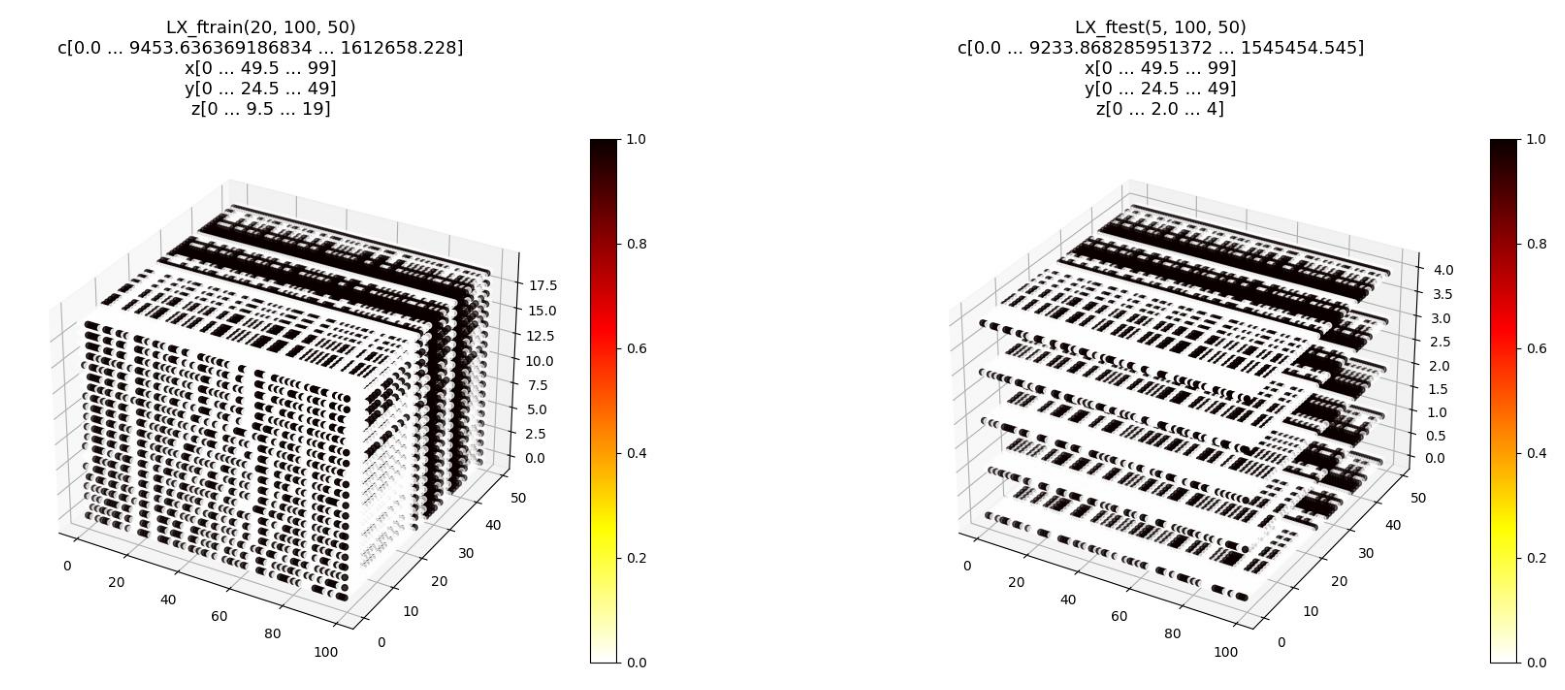

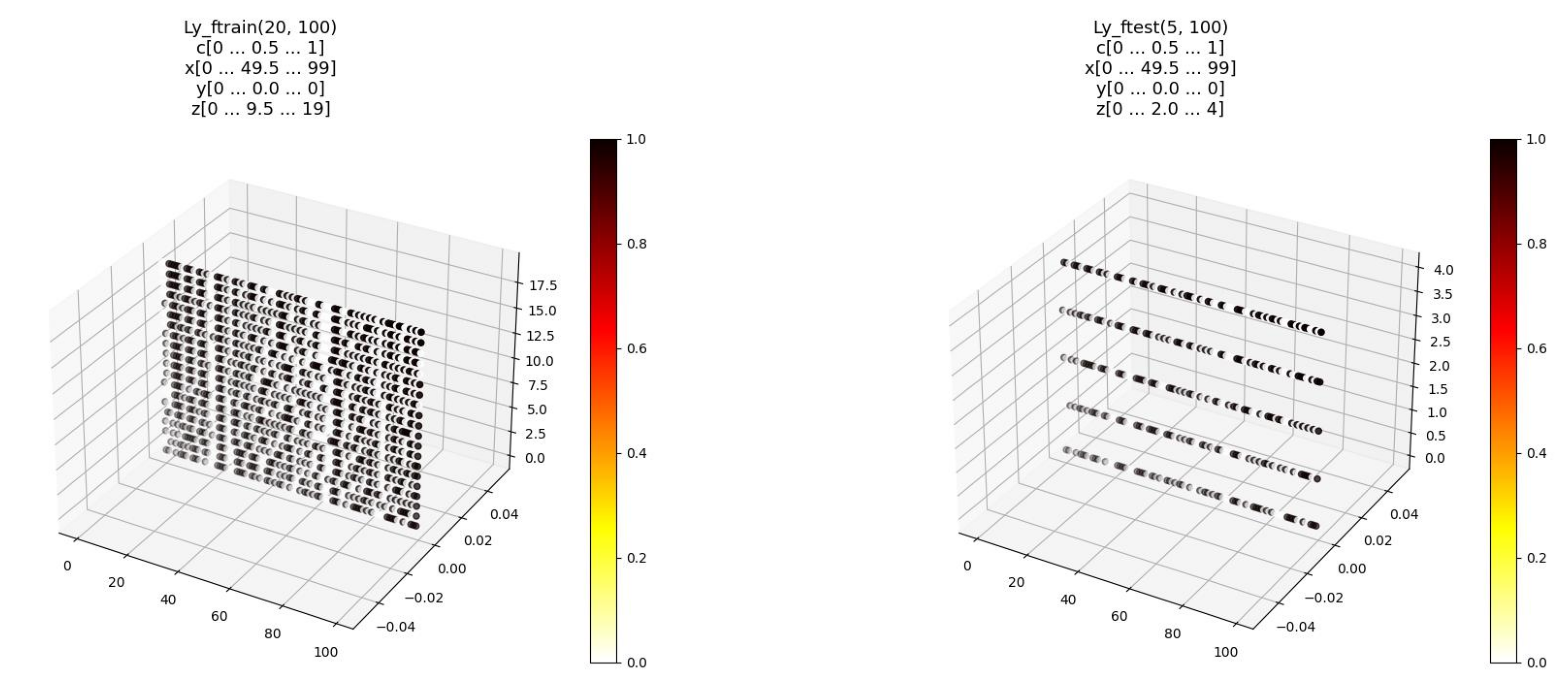

In [12]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_ftrain','LX_ftest'])
show_4d_imgs(['Ly_ftrain','Ly_ftest'])

# 4.INTRODUCTION

To create powerful models, especially for solving Seq2Seq learning problems, LSTM is the key layer.
To use LSTM effectively in models, we need to understand how it generates different results with respect to given parameters.

## 4.1.QUICK RECAP OF LSTM

### 4.1.1.Internal Structure

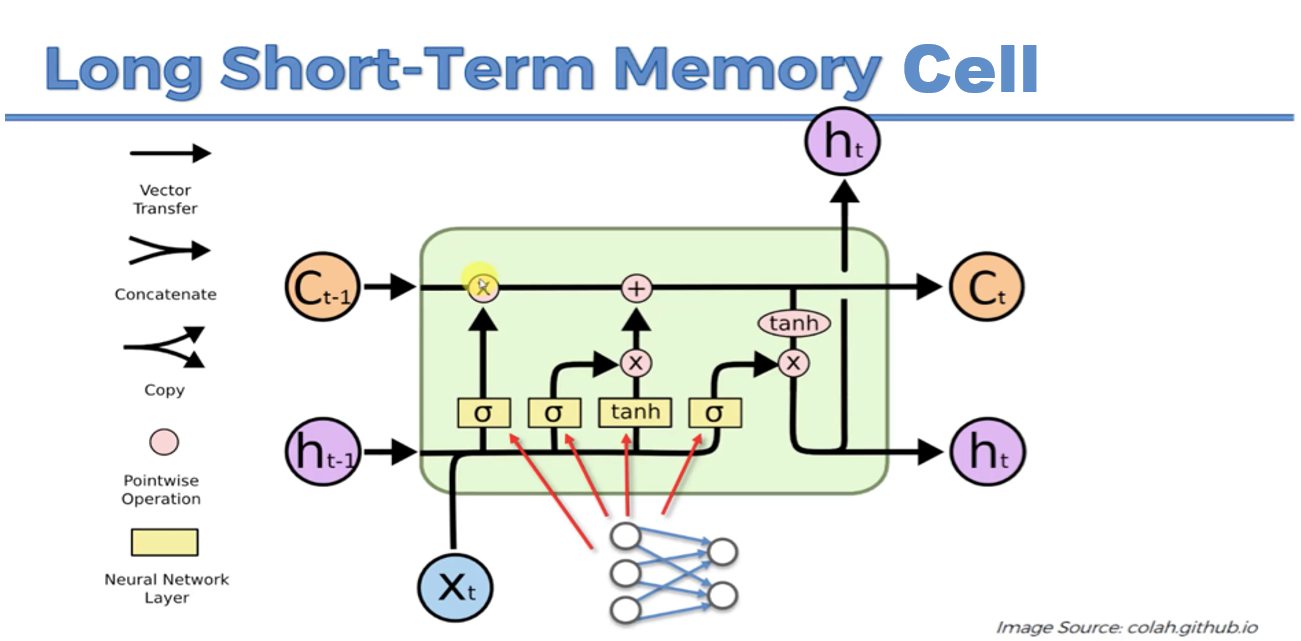

### 4.1.2.Roll-Out Representation of LSTM for each Time Step

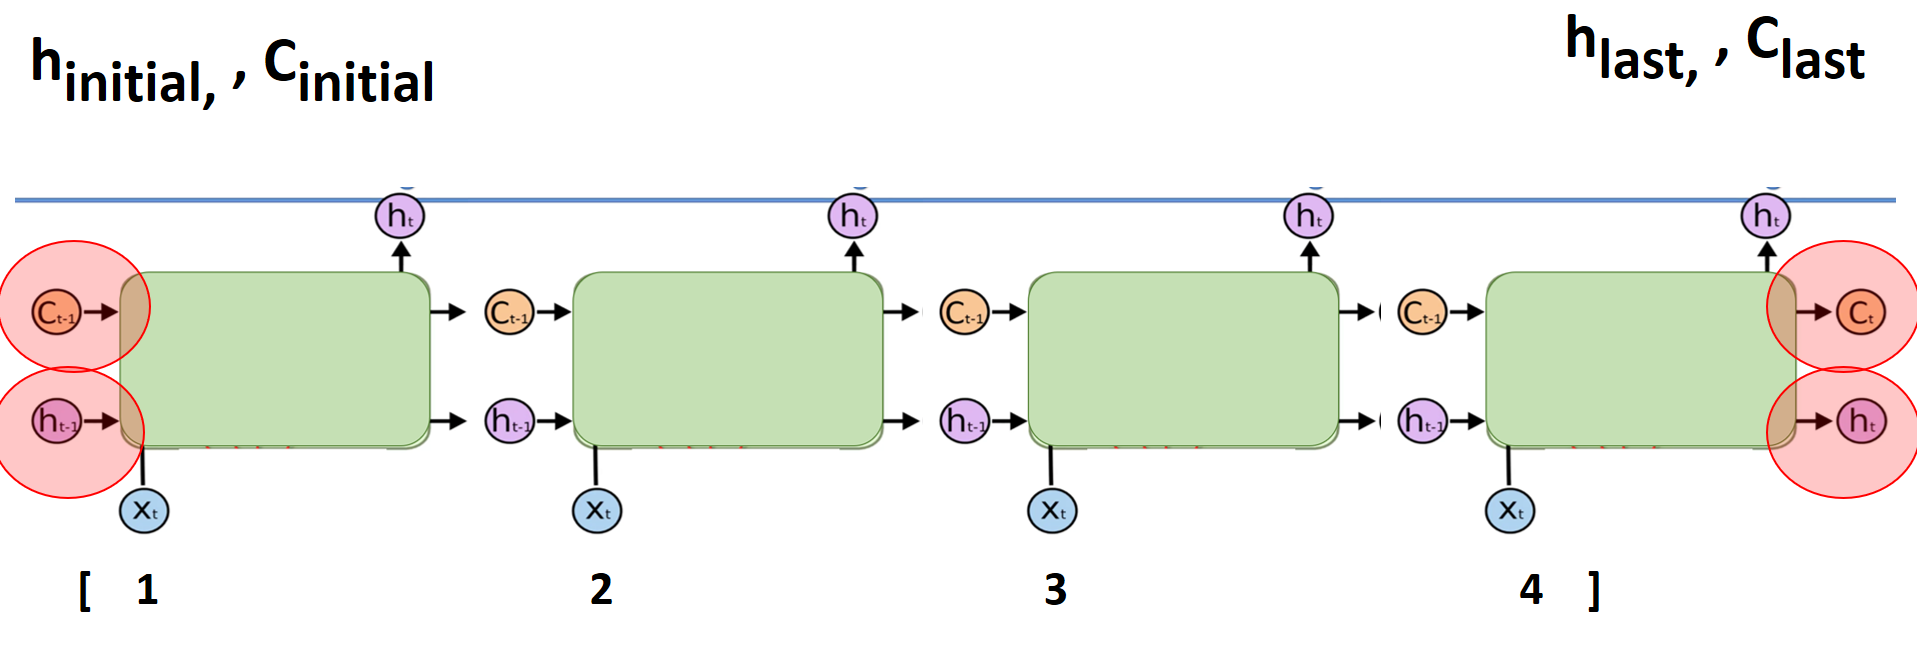

# 5.LSTM Anomaly State management

## 5.1.Model layers



In [13]:
def new_model5():
  num_outputs = 2
  # Define input layers
  input_layer = tf.keras.layers.Input(shape=(None, n_features), name="inputs")
  state_in_h = tf.keras.layers.Input(shape=(cell_size,), name="h")
  state_in_c = tf.keras.layers.Input(shape=(cell_size,), name="c")
  #seq_in = tf.keras.layers.Input(shape=(), name="seq_in", dtype=tf.int32)

  # Preprocess observation with a hidden layer and send to LSTM cell
  dense1 = tf.keras.layers.Dense(hidden_size, activation=tf.keras.activations.linear, name="dense1")(input_layer)
  lstm_out, state_h, state_c = tf.keras.layers.LSTM(
      cell_size, return_sequences=True, return_state=True, name="lstm")(
      inputs=dense1,
      #mask=tf.sequence_mask(seq_in),
      initial_state=[state_in_h, state_in_c]
      )

  # Postprocess LSTM output with another hidden layer and compute values
  logits = tf.keras.layers.Dense(
      num_outputs,
      activation=tf.keras.activations.linear,
      name="logits")(lstm_out)
  values = tf.keras.layers.Dense(
      1, activation="sigmoid", name="values")(lstm_out)

  # Create the RNN model
  model5: Model = Model(
      inputs=
      [
        input_layer,
        #seq_in,
        state_in_h,
        state_in_c
      ],
      outputs=[logits, values, state_h, state_c])
  return model5

model5 = new_model5()
model5.summary()

h = np.zeros((train_size, cell_size), np.float32)
c = np.zeros((train_size, cell_size), np.float32)
IMG['h'], IMG['c'] = ray.get([
    show_scattered_4d.remote(h, "h"),
    show_scattered_4d.remote(c, "c"),
])

2023-01-25 02:21:47.965979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1240 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-01-25 02:21:47.966769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13129 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-01-25 02:21:47.967498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13129 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-01-25 02:21:47.969638: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13129 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:42:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 50)]   0           []                               
                                                                                                  
 dense1 (Dense)                 (None, None, 128)    6528        ['inputs[0][0]']                 
                                                                                                  
 h (InputLayer)                 [(None, 256)]        0           []                               
                                                                                                  
 c (InputLayer)                 [(None, 256)]        0           []                               
                                                                                              

## 5.2.Train



In [14]:
#@title state function

def train_state(model, x=LX_ftrain, h=h, c=c, y=Ly_ftrain, title=['model5', 'LX_ftrain', 'h', 'c', 'Ly_ftrain']):
  compile = model.predict([x, h, c])
  IMG[f"{title[4]}_predicted"], IMG[f"{title[4]}_h"], IMG[f"{title[4]}_c"] = ray.get([
    show_scattered_4d.remote(compile[1], f"{title[4]}_predicted"),
    show_scattered_4d.remote(compile[2], f"{title[4]}_h"),
    show_scattered_4d.remote(compile[3], f"{title[4]}_c"),
  ])

  show_4d_imgs([title[1], title[4], f"{title[4]}_predicted"])
  show_4d_imgs([title[1], title[2], f"{title[4]}_h"])
  show_4d_imgs([title[1], title[3], f"{title[4]}_c"])

In [15]:
#@title train state

#model5.compile("adam", "binary_crossentropy", metrics=["accuracy"])
train_state(new_model5(), LX_ftrain, h, c, Ly_ftrain, ['model5', 'LX_ftrain', 'h', 'c', 'Ly_ftrain'])

2023-01-25 02:21:50.024362: E tensorflow/stream_executor/cuda/cuda_blas.cc:226] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2023-01-25 02:21:50.024433: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at matmul_op_impl.h:442 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support


InternalError:  Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[node model_1/dense1/Tensordot/MatMul
 (defined at /usr/local/lib/python3.7/dist-packages/keras/layers/core/dense.py:202)
]] [Op:__inference_predict_function_1766]

Errors may have originated from an input operation.
Input Source operations connected to node model_1/dense1/Tensordot/MatMul:
In[0] model_1/dense1/Tensordot/Reshape:	
In[1] model_1/dense1/Tensordot/ReadVariableOp:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
>>>     "__main__", mod_spec)
>>> 
>>>   File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 17, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 992, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 712, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/tornado/platform/asyncio.py", line 215, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.7/asyncio/events.py", line 88, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py", line 387, in do_execute
>>>     cell_id=cell_id,
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
>>>     raw_cell, store_history, silent, shell_futures, cell_id
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
>>>     interactivity=interactivity, compiler=compiler, result=result)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_728/814422039.py", line 4, in <module>
>>>     train_state(new_model5(), LX_ftrain, h, c, Ly_ftrain, ['model5', 'LX_ftrain', 'h', 'c', 'Ly_ftrain'])
>>> 
>>>   File "/tmp/ipykernel_728/1210997455.py", line 4, in train_state
>>>     compile = model.predict([x, h, c])
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1789, in predict
>>>     tmp_batch_outputs = self.predict_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1621, in predict_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1611, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1604, in run_step
>>>     outputs = model.predict_step(data)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1572, in predict_step
>>>     return self(x, training=False)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py", line 452, in call
>>>     inputs, training=training, mask=mask)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/layers/core/dense.py", line 202, in call
>>>     outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
>>> 

In [ ]:
#@title train function
def ftrain(model, name='model'):
  model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
  history = model.fit(LX_ftrain, Ly_ftrain, batch_size=batch_size, epochs=epochs, validation_data=(LX_ftest, Ly_ftest))
  show_train_metric(history, name)
  model.save(f"/cic/models/{name}")

In [ ]:
## 5.3.Infer

In [ ]:
#@title infer function

def finfer(name='model'):
  model = keras.models.load_model(f"/cic/models/{name}")
  ##############LX_ftrain
  L_fresult1=model.predict(LX_ftrain)
  ##############LX_ftest
  L_fresult2=model.predict(LX_ftest)

  IMG['Ly_ftrain_predicted'], IMG['Ly_ftest_predicted'] = ray.get([
    show_scattered_4d.remote(L_fresult1, "Ly_ftrain_predicted"),
    show_scattered_4d.remote(L_fresult2, "Ly_ftest_predicted"),
  ])
  show_4d_imgs(['LX_ftrain','Ly_ftrain','Ly_ftrain_predicted'])
  show_4d_imgs(['LX_ftest','Ly_ftest','Ly_ftest_predicted'])


___

# 6.LSTM Anomaly model (Primary)

## 6.1.Model layers



In [ ]:
def new_model6():
  num_outputs = 10
  # Define input layers
  input_layer = tf.keras.layers.Input(shape=(None, n_features), name="inputs")
  #state_in_h = tf.keras.layers.Input(shape=(cell_size,), name="h")
  #state_in_c = tf.keras.layers.Input(shape=(cell_size,), name="c")
  #seq_in = tf.keras.layers.Input(shape=(), name="seq_in", dtype=tf.int32)

  # Preprocess observation with a hidden layer and send to LSTM cell
  #tf.nn.sigmoid
  dense1 = tf.keras.layers.Dense(hidden_size, activation=tf.nn.relu, name="dense1")(input_layer)
  lstm_out, state_h, state_c = tf.keras.layers.LSTM(
      cell_size, return_sequences=True, return_state=True, name="lstm")(
      inputs=dense1,
      #mask=tf.sequence_mask(seq_in),
      #initial_state=[state_in_h, state_in_c]
      )

  # Postprocess LSTM output with another hidden layer and compute values
  logits = tf.keras.layers.Dense(
      num_outputs,
      activation=tf.keras.activations.linear,
      name="logits")(lstm_out)
  values = tf.keras.layers.Dense(
      1, activation="sigmoid", name="values")(lstm_out)

  # Create the RNN model
  model6: Model = Model(
      inputs=input_layer,
      #[
      #  input_layer, #seq_in,
      #  state_in_h,
      #  state_in_c
      #],
      outputs=values
      #[
      #  logits,
      #  values,
      #  state_h,
      #  state_c
      #]
      )
  return model6

model6 = new_model6()
model6.summary()

## 6.2.Train



In [ ]:
ftrain(model6, 'model6')

## 6.3.Infer



In [ ]:
finfer('model6')

# 7.MODEL WEIGHTS SUMMARY

In [ ]:
weights5 = show_weights(model5, 'model5')
weights6 = show_weights(model6, 'model6')

show_4d_imgs(weights5)
show_4d_imgs(weights6)